In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import cv2
import numpy as np
np.random.seed(42)
import os
import matplotlib.pyplot as plt
import glob
import pandas as pd

import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras import layers

In [3]:
"""

Here, we are resizing them to 128x128 that will be  used as HR images and 
32x32 that will be used as LR images
"""

train_dir = "/content/gdrive/MyDrive/Colab Notebooks/A5/Data_Small/train" 

# Test data
test_dir = "/content/gdrive/MyDrive/Colab Notebooks/A5/Data_Small/test"


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# DME images from train folder
train_DME = train_dir+"/DME"

# DRUSEN images from train folder
train_DRUSEN = train_dir+"/DRUSEN"

data = [] 

# get a list of all image files in the folder 
image_train_DME = glob.glob(os.path.join(train_DME, '*.jpg')) + glob.glob(os.path.join(train_DME, '*.jpeg')) + glob.glob(os.path.join(train_DME, '*.png'))

# iterate through the list of image files
for file in image_train_DME:

     image = {"label": 1, "image_path" : file }
     data.append(image)

# get a list of all image files in the folder 
image_train_DRUSEN = glob.glob(os.path.join(train_DRUSEN, '*.jpg')) + glob.glob(os.path.join(train_DRUSEN, '*.jpeg')) + glob.glob(os.path.join(train_DRUSEN, '*.png'))

# iterate through the list of image files
for file in image_train_DRUSEN:

     image = {"label": 0, "image_path" : file }
     data.append(image)


# making data into a dataframe
df = pd.DataFrame(data)

# shuffle the DataFrame rows
df = df.sample(frac = 1, random_state=42)

# DME = 1, DRUSEN = 0
df

""


In [6]:
"""
for class_name in ["DME", "DRUSEN"]:
    for img in os.listdir(train_dir + "/" + class_name):
        img_array = cv2.imread(train_dir + "/" + class_name + "/" + img)
        
        img_array = cv2.resize(img_array, (128,128))
        lr_img_array = cv2.resize(img_array,(32,32))
        cv2.imwrite(train_dir+ "/hr_images/" + img + "_" + class_name, img_array)
        cv2.imwrite(train_dir+ "/lr_images/" + img + "_" + class_name, lr_img_array)
"""

'\nfor class_name in ["DME", "DRUSEN"]:\n    for img in os.listdir(train_dir + "/" + class_name):\n        img_array = cv2.imread(train_dir + "/" + class_name + "/" + img)\n        \n        img_array = cv2.resize(img_array, (128,128))\n        lr_img_array = cv2.resize(img_array,(32,32))\n        cv2.imwrite(train_dir+ "/hr_images/" + img + "_" + class_name, img_array)\n        cv2.imwrite(train_dir+ "/lr_images/" + img + "_" + class_name, lr_img_array)\n'

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)


Mounted at /content/gdrive


In [ ]:
for class_name in ["DME", "DRUSEN"]:
    hr_dir = train_dir + "/hr_images_" + class_name
    lr_dir = train_dir + "/lr_images_" + class_name
    os.makedirs(hr_dir, exist_ok=True)
    os.makedirs(lr_dir, exist_ok=True)
    for img in os.listdir(train_dir + "/" + class_name):
        img_array = cv2.imread(train_dir + "/" + class_name + "/" + img)
        
        img_array = cv2.resize(img_array, (128,128))
        lr_img_array = cv2.resize(img_array,(32,32))
        cv2.imwrite(hr_dir + "/" + img, img_array)
        cv2.imwrite(lr_dir + "/" + img, lr_img_array)

In [ ]:
import matplotlib.pyplot as plt
import os

class_name = "DME"  # choose which class to visualize
hr_dir = train_dir + "/hr_images_" + class_name
lr_dir = train_dir + "/lr_images_" + class_name

# get a list of image file names
img_files = os.listdir(hr_dir)

# choose how many images to visualize
num_images = 5

# plot the images
fig, ax = plt.subplots(num_images, 2, figsize=(8, 16))
for i in range(num_images):
    # read the high-resolution image
    hr_img = plt.imread(os.path.join(hr_dir, img_files[i]))
    # read the low-resolution image
    lr_img = plt.imread(os.path.join(lr_dir, img_files[i]))
    # plot the images side by side
    ax[i, 0].imshow(hr_img)
    ax[i, 1].imshow(lr_img)
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()
print('hr_img.shape:', hr_img.shape)
print('lr_img.shape:', lr_img.shape)

In [ ]:
class_name = "DRUSEN"  # choose which class to visualize
hr_dir = train_dir + "/hr_images_" + class_name
lr_dir = train_dir + "/lr_images_" + class_name

# get a list of image file names
img_files = os.listdir(hr_dir)

# choose how many images to visualize
num_images = 5

# plot the images
fig, ax = plt.subplots(num_images, 2, figsize=(8, 16))
for i in range(num_images):
    # read the high-resolution image
    hr_img = plt.imread(os.path.join(hr_dir, img_files[i]))
    # read the low-resolution image
    lr_img = plt.imread(os.path.join(lr_dir, img_files[i]))
    # plot the images side by side
    ax[i, 0].imshow(hr_img)
    ax[i, 1].imshow(lr_img)
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()
print('hr_img.shape:', hr_img.shape)
print('lr_img.shape:', lr_img.shape)

In [12]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras import layers, Model
from sklearn.model_selection import train_test_split

import numpy as np
from keras import Model
from keras.layers import Conv2D, PReLU,BatchNormalization, Flatten
from keras.layers import UpSampling2D, LeakyReLU, Dense, Input, add
from tqdm import tqdm

In [ ]:
#Define blocks to build the generator
def res_block(ip):
    
    res_model = Conv2D(64, (3,3), padding = "same")(ip)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    res_model = PReLU(shared_axes = [1,2])(res_model)
    
    res_model = Conv2D(64, (3,3), padding = "same")(res_model)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    
    return add([ip,res_model])

def upscale_block(ip):
    
    up_model = Conv2D(256, (3,3), padding="same")(ip)
    up_model = UpSampling2D( size = 2 )(up_model)
    up_model = PReLU(shared_axes=[1,2])(up_model)
    
    return up_model

In [ ]:
#Generator model
def create_gen(gen_ip, num_res_block):
    layers = Conv2D(64, (9,9), padding="same")(gen_ip)
    layers = PReLU(shared_axes=[1,2])(layers)

    temp = layers

    for i in range(num_res_block):
        layers = res_block(layers)

    layers = Conv2D(64, (3,3), padding="same")(layers)
    layers = BatchNormalization(momentum=0.5)(layers)
    layers = add([layers,temp])

    layers = upscale_block(layers)
    layers = upscale_block(layers)

    op = Conv2D(3, (9,9), padding="same")(layers)

    return Model(inputs=gen_ip, outputs=op)

In [ ]:
#Descriminator block that will be used to construct the discriminator
def discriminator_block(ip, filters, strides=1, bn=True):
    
    disc_model = Conv2D(filters, (3,3), strides = strides, padding="same")(ip)
    
    if bn:
        disc_model = BatchNormalization( momentum=0.8 )(disc_model)
    
    disc_model = LeakyReLU( alpha=0.2 )(disc_model)
    
    return disc_model

In [ ]:
#Descriminartor, as described in the original paper
def create_disc(disc_ip):

    df = 64
    
    d1 = discriminator_block(disc_ip, df, bn=False)
    d2 = discriminator_block(d1, df, strides=2)
    d3 = discriminator_block(d2, df*2)
    d4 = discriminator_block(d3, df*2, strides=2)
    d5 = discriminator_block(d4, df*4)
    d6 = discriminator_block(d5, df*4, strides=2)
    d7 = discriminator_block(d6, df*8)
    d8 = discriminator_block(d7, df*8, strides=2)
    
    d8_5 = Flatten()(d8)
    d9 = Dense(df*16)(d8_5)
    d10 = LeakyReLU(alpha=0.2)(d9)
    validity = Dense(1, activation='sigmoid')(d10)

    return Model(disc_ip, validity)

In [ ]:
#VGG19 
#We need VGG19 for the feature map obtained by the j-th convolution (after activation) 
#before the i-th maxpooling layer within the VGG19 network.(as described in the paper)
#Let us pick the 3rd block, last conv layer. 
#Build a pre-trained VGG19 model that outputs image features extracted at the
# third block of the model
# VGG architecture: https://github.com/keras-team/keras/blob/master/keras/applications/vgg19.py
from keras.applications import VGG19

def build_vgg(hr_shape):
    
    vgg = VGG19(weights="imagenet",include_top=False, input_shape=hr_shape)
    
    return Model(inputs=vgg.inputs, outputs=vgg.layers[10].output)

In [ ]:
#Combined model
def create_comb(gen_model, disc_model, vgg, lr_ip, hr_ip):
    gen_img = gen_model(lr_ip)
    
    gen_features = vgg(gen_img)
    
    disc_model.trainable = False
    validity = disc_model(gen_img)
    
    return Model(inputs=[lr_ip, hr_ip], outputs=[validity, gen_features])


In [ ]:
# 2 losses... adversarial loss and content (VGG) loss
#AdversariaL: is defined based on the probabilities of the discriminator over all training samples
# use binary_crossentropy

#Content: feature map obtained by the j-th convolution (after activation) 
#before the i-th maxpooling layer within the VGG19 network.
# MSE between the feature representations of a reconstructed image
# and the reference image. 

###################################################################################

#Load first n number of images (to train on a subset of all images)
#For demo purposes, let us use 5000 images
"""
n=1000
lr_list = os.listdir("/content/gdrive/MyDrive/ECGR5090/Data_Small/train/lr_images")[:n]

lr_images = []
for img in lr_list:
    img_lr = cv2.imread("/content/gdrive/MyDrive/ECGR5090/Data_Small/train/lr_images/" + img)
    img_lr = cv2.cvtColor(img_lr, cv2.COLOR_BGR2RGB)
    lr_images.append(img_lr)   


hr_list = os.listdir("/content/gdrive/MyDrive/ECGR5090/Data_Small/train/hr_images")[:n]
   
hr_images = []
for img in hr_list:
    img_hr = cv2.imread("/content/gdrive/MyDrive/ECGR5090/Data_Small/train/hr_images/" + img)
    img_hr = cv2.cvtColor(img_hr, cv2.COLOR_BGR2RGB)
    hr_images.append(img_hr)   

lr_images = np.array(lr_images)
hr_images = np.array(hr_images)
"""

In [ ]:
n = 1000

lr_images = []
hr_images = []

for class_name in ["DME", "DRUSEN"]:
    lr_list = os.listdir("/content/gdrive/MyDrive/ECGR5090/Data_Small/train/lr_images_" + class_name)[:n]
    for img in lr_list:
        img_lr = cv2.imread("/content/gdrive/MyDrive/ECGR5090/Data_Small/train/lr_images_" + class_name + "/" + img)
        img_lr = cv2.cvtColor(img_lr, cv2.COLOR_BGR2RGB)
        lr_images.append(img_lr)   
    
    hr_list = os.listdir("/content/gdrive/MyDrive/ECGR5090/Data_Small/train/hr_images_" + class_name)[:n]
    for img in hr_list:
        img_hr = cv2.imread("/content/gdrive/MyDrive/ECGR5090/Data_Small/train/hr_images_" + class_name + "/" + img)
        img_hr = cv2.cvtColor(img_hr, cv2.COLOR_BGR2RGB)
        hr_images.append(img_hr) 

lr_images = np.array(lr_images)
hr_images = np.array(hr_images)


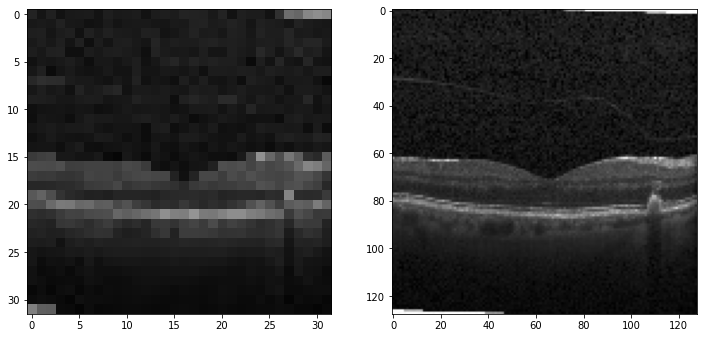

In [ ]:
#Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(lr_images)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(lr_images[image_number], (32, 32, 3)))
plt.subplot(122)
plt.imshow(np.reshape(hr_images[image_number], (128, 128, 3)))
plt.show()

In [ ]:
#Scale values
lr_images = lr_images / 255.
hr_images = hr_images / 255.


In [ ]:
import tensorflow as tf
data_augmentation = tf.keras.Sequential([
  layers.Resizing(32,32),
  layers.Rescaling(1./255),
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [ ]:
import os
import random
from shutil import copyfile

# Define the parent directory of the dataset
data_dir = '/content/gdrive/MyDrive/ECGR5090/Data_Small/train/dataset'

# Define the subdirectories for the train set
train_subdirs = ['hr_images_DME', 'hr_images_DRUSEN', 'lr_images_DME', 'lr_images_DRUSEN']

# Define the percentage of images to use for the train set
train_pct = 0.7

# Loop over the subdirectories and split the images into train and test sets
for subdir in train_subdirs:
    subdir_path = os.path.join(data_dir, subdir)
    files = os.listdir(subdir_path)
    files = [os.path.join(subdir_path, file) for file in files]

    # Shuffle the files randomly
    random.shuffle(files)

    # Split the files into train and test sets
    train_files = files[:int(len(files) * train_pct)]
    test_files = files[int(len(files) * train_pct):]

    # Copy the train files to the train directory
    for file in train_files:
        filename = os.path.basename(file)
        dst_path = os.path.join(data_dir, 'train', filename)
        copyfile(file, dst_path)

    # Copy the test files to the test directory
    for file in test_files:
        filename = os.path.basename(file)
        dst_path = os.path.join(data_dir, 'test', filename)
        copyfile(file, dst_path)

    print('Finished splitting images for subdirectory:', subdir)

print('All images have been split into train and test sets.')


Train data: ['hr_images_DME', 'hr_images_DRUSEN']
Test data: ['lr_images_DME', 'lr_images_DRUSEN']


str

In [ ]:



lr_train, lr_test, hr_train, hr_test = train_test_split(train_dir, hr_images, 
                                                      test_size=0.30, random_state=42)



hr_shape = (hr_train.shape[1], hr_train.shape[2], hr_train.shape[3])
lr_shape = (lr_train.shape[1], lr_train.shape[2], lr_train.shape[3])

lr_ip = Input(shape=lr_shape)
hr_ip = Input(shape=hr_shape)

generator = create_gen(lr_ip, num_res_block = 16)
generator.summary()

discriminator = create_disc(hr_ip)
discriminator.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
discriminator.summary()

vgg = build_vgg((128,128,3))
print(vgg.summary())
vgg.trainable = False

gan_model = create_comb(generator, discriminator, vgg, lr_ip, hr_ip)

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_90 (Conv2D)             (None, 32, 32, 64)   15616       ['input_6[0][0]']                
                                                                                                  
 p_re_lu_38 (PReLU)             (None, 32, 32, 64)   64          ['conv2d_90[0][0]']              
                                                                                                  
 conv2d_91 (Conv2D)             (None, 32, 32, 64)   36928       ['p_re_lu_38[0][0]']             
                                                                                            

In [ ]:
# 2 losses... adversarial loss and content (VGG) loss
#AdversariaL: is defined based on the probabilities of the discriminator over all training samples
# use binary_crossentropy

#Content: feature map obtained by the j-th convolution (after activation) 
#before the i-th maxpooling layer within the VGG19 network.
# MSE between the feature representations of a reconstructed image
# and the reference image. 
gan_model.compile(loss=["binary_crossentropy", "mse"], loss_weights=[1e-3, 1], optimizer="adam", metrics=['accuracy'])
gan_model.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 model_6 (Functional)           (None, 128, 128, 3)  2044291     ['input_6[0][0]']                
                                                                                                  
 input_7 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_7 (Functional)           (None, 1)            38249281    ['model_6[0][0]']          

In [ ]:
#Create a list of images for LR and HR in batches from which a batch of images
#would be fetched during training. 
batch_size = 1  
train_lr_batches = []
train_hr_batches = []
for it in range(int(hr_train.shape[0] / batch_size)):
    start_idx = it * batch_size
    end_idx = start_idx + batch_size
    train_hr_batches.append(hr_train[start_idx:end_idx])
    train_lr_batches.append(lr_train[start_idx:end_idx])

In [ ]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [ ]:
train(train_dataset, EPOCHS)

In [ ]:
#Create a list of images for LR and HR in batches from which a batch of images
#would be fetched during training. 
batch_size = 1  
train_lr_batches = []
train_hr_batches = []
for it in range(int(hr_train.shape[0] / batch_size)):
    start_idx = it * batch_size
    end_idx = start_idx + batch_size
    train_hr_batches.append(hr_train[start_idx:end_idx])
    train_lr_batches.append(lr_train[start_idx:end_idx])

In [ ]:
epochs = 50
#Enumerate training over epochs
for e in range(epochs):
    
    fake_label = np.zeros((batch_size, 1)) # Assign a label of 0 to all fake (generated images)
    real_label = np.ones((batch_size,1)) # Assign a label of 1 to all real images.
    
    #Create empty lists to populate gen and disc losses. 
    g_losses = []
    d_losses = []

In [ ]:
   #Enumerate training over batches. 
    for b in tqdm(range(len(train_hr_batches))):
        lr_imgs = train_lr_batches[b] #Fetch a batch of LR images for training
        hr_imgs = train_hr_batches[b] #Fetch a batch of HR images for training

100%|██████████| 1400/1400 [00:00<00:00, 932956.09it/s]


In [ ]:
fake_imgs = generator.predict_on_batch(lr_imgs) #Fake images

In [ ]:
        #First, train the discriminator on fake and real HR images. 
discriminator.trainable = True
d_loss_gen = discriminator.train_on_batch(fake_imgs, fake_label)
d_loss_real = discriminator.train_on_batch(hr_imgs, real_label)

In [ ]:
        #Now, train the generator by fixing discriminator as non-trainable
discriminator.trainable = False

In [ ]:
        #Average the discriminator loss, just for reporting purposes. 
d_loss = 0.5 * np.add(d_loss_gen, d_loss_real) 

In [ ]:
        #Extract VGG features, to be used towards calculating loss
image_features = vgg.predict(hr_imgs)

1/1 [==============================] - 0s 20ms/step


In [ ]:
        #Train the generator via GAN. 
        #Remember that we have 2 losses, adversarial loss and content (VGG) loss
g_loss, _, _ = gan_model.train_on_batch([lr_imgs, hr_imgs], [real_label, image_features])

In [ ]:
        #Save losses to a list so we can average and report. 
d_losses.append(d_loss)
g_losses.append(g_loss)

In [ ]:
    #Convert the list of losses to an array to make it easy to average    
g_losses = np.array(g_losses)
d_losses = np.array(d_losses)

In [ ]:
    #Calculate the average losses for generator and discriminator
g_loss = np.sum(g_losses, axis=0) / len(g_losses)
d_loss = np.sum(d_losses, axis=0) / len(d_losses)

In [ ]:
    #Report the progress during training. 
print("epoch:", e+1 ,"g_loss:", g_loss, "d_loss:", d_loss)

if (e+1) % 10 == 0: #Change the frequency for model saving, if needed
        #Save the generator after every n epochs (Usually 10 epochs)
        generator.save("gen_e_"+ str(e+1) +".h5")


epoch: 50 g_loss: 387.1916809082031 d_loss: [4.46856538e-05 1.00000000e+00]


In [ ]:
###################################################################################
#Test - perform super resolution using saved generator model
from keras.models import load_model
from numpy.random import randint

In [ ]:
!pwd

/content


In [ ]:
generator = load_model('gen_e_50.h5', compile=False)


In [ ]:
[X1, X2] = [lr_test, hr_test]
# select random example
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]


In [ ]:
# generate image from source
gen_image = generator.predict(src_image)


1/1 [==============================] - 1s 687ms/step


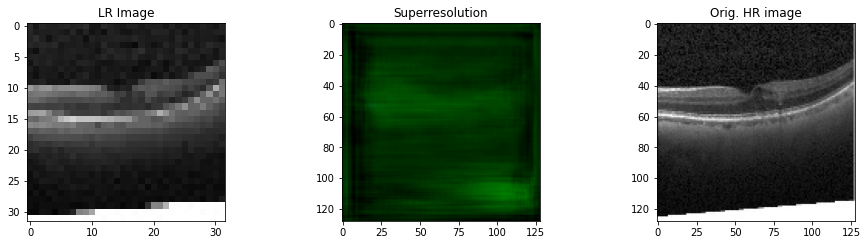

In [ ]:
# plot all three images

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(src_image[0,:,:,:])
plt.subplot(232)
plt.title('Superresolution')
plt.imshow(gen_image[0,:,:,:])
plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(tar_image[0,:,:,:])
plt.show()

In [ ]:
################################################
lr_images_DME = cv2.imread("/content/gdrive/MyDrive/ECGR5090/Data_Small/train/lr_images_DME/DME-1072015-4.jpeg")
hr_images_DME = cv2.imread("/content/gdrive/MyDrive/ECGR5090/Data_Small/train/hr_images_DME/DME-1072015-4.jpeg")
lr_images_DRUSEN = cv2.imread("/content/gdrive/MyDrive/ECGR5090/Data_Small/train/lr_images_DRUSEN/DRUSEN-1001666-4.jpeg")
hr_images_DRUSEN = cv2.imread("/content/gdrive/MyDrive/ECGR5090/Data_Small/train/hr_images_DRUSEN/DRUSEN-1001666-4.jpeg")


In [ ]:
#Change images from BGR to RGB for plotting. 
#Remember that we used cv2 to load images which loads as BGR.
lr_images_DME = cv2.cvtColor(lr_images_DME, cv2.COLOR_BGR2RGB)
hr_images_DME = cv2.cvtColor(hr_images_DME, cv2.COLOR_BGR2RGB)
lr_images_DRUSEN = cv2.cvtColor(lr_images_DRUSEN, cv2.COLOR_BGR2RGB)
hr_images_DRUSEN = cv2.cvtColor(hr_images_DRUSEN, cv2.COLOR_BGR2RGB)

In [ ]:
lr_images_DME = lr_images_DME / 255.
hr_images_DME = hr_images_DME / 255.
lr_images_DRUSEN = lr_images_DRUSEN / 255.
hr_images_DRUSEN = hr_images_DRUSEN / 255.

In [ ]:
lr_images_DME = np.expand_dims(lr_images_DME, axis=0)
hr_images_DME = np.expand_dims(hr_images_DME, axis=0)
lr_images_DRUSEN = np.expand_dims(lr_images_DRUSEN, axis=0)
hr_images_DRUSEN = np.expand_dims(hr_images_DRUSEN, axis=0)

In [ ]:
generated_lr_images_DME = generator.predict(lr_images_DME)
generated_hr_images_DME = generator.predict(hr_images_DME)
#generated_lr_images_DRUSEN = generator.predict(lr_images_DRUSEN)
#generated_hr_images_DRUSEN = generator.predict(hr_images_DRUSEN)

1/1 [==============================] - 0s 26ms/step


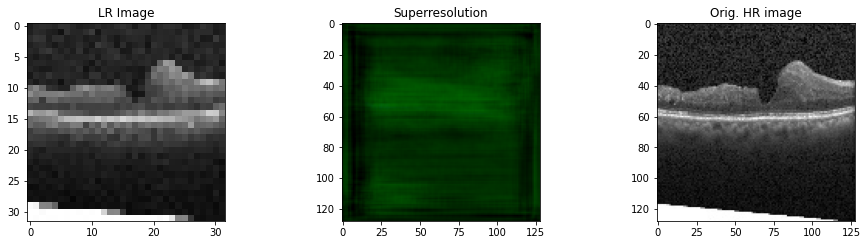

In [ ]:
# plot all three images
plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(lr_images_DME[0,:,:,:])
plt.subplot(232)
plt.title('Superresolution')
plt.imshow(generated_lr_images_DME[0,:,:,:])
plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(hr_images_DME[0,:,:,:])

plt.show()

In [ ]:
lr_images_DRUSEN.shape

(1, 1, 32, 32, 3)